In [1]:
from Modules.Homer import *

from Modules.Annotation_helper import *
from Modules.helper import *

In [2]:
import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
import tqdm
### notebook specific configuration ###
from os.path import basename
mpl.style.use('fivethirtyeight')

In [3]:
ref_fa = '/data/genome/hamster/picr/picr.fa'
annotation = '/data/genome/hamster/picr/updated_final_sort.gff3'


In [4]:
genome_anno = add_fields_new_annotation('/data/isshamie/TSS_CHO/mRNA.peak')
genome_anno_collapsed = genome_anno.drop_duplicates(subset='gene_id') # Create df indexed by gene_id
genome_anno_collapsed.set_index('gene_id',inplace=True)

print len(genome_anno_collapsed)

34338


## Annotate based on totalRNA

In [5]:
peak_anno = pd.read_csv('CHO/mSTART/f06_annoPeaks/merge_bg_2.anno',index_col=0,sep='\t')
peak_anno.dropna(axis=1,how='all',inplace=True)
peak_anno.head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Distance to TSS,Nearest PromoterID
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg_2.peak /data/genome/hamster/picr/picr.fa -gff /data/genome/hamster/picr/updated_final_sort.gff3),,,,,,,,,
Merged-picr_116-2882832-2,picr_116,2882757,2882907,+,167570.703125,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,Intergenic,-21206.0,ID=asmbl_11628.exon1;Parent=asmbl_11628;gene_i...
Merged-picr_56-12601855-2,picr_56,12601780,12601930,+,62621.500000,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,Intergenic,19076.0,ID=asmbl_63869.exon11;Parent=asmbl_63869;gene_...
Merged-picr_54-1311935-2,picr_54,1311860,1312010,+,60447.000000,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,Intergenic,69544.0,ID=asmbl_62111.exon1;Parent=asmbl_62111;gene_i...
Merged-picr_36-10050726-2,picr_36,10050651,10050801,-,46534.601562,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,promoter-TSS (ID=asmbl_48620.exon2;Parent=asmb...,9.0,ID=asmbl_48569.exon1;Parent=asmbl_48569;gene_i...
Merged-picr_160-705648-2,picr_160,705573,705723,+,45987.101562,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,exon (ID=asmbl_25152.exon1;Parent=asmbl_25152;...,103.0,ID=asmbl_25152.exon1;Parent=asmbl_25152;gene_i...


In [6]:
tss_totalRNA = pd.read_csv('CH_tissue_RNA/totalRNA_mrna.peak',sep='\t',index_col=0)
tss_totalRNA.head()

,Chr,Start,End,Strand
ID,,,,
"gene_id ""MSTRG.1""; transcript_id ""MSTRG.1.1"";",picr_0,49671,49673,-
"gene_id ""MSTRG.2""; transcript_id ""MSTRG.2.1"";",picr_0,133873,133875,-
"gene_id ""MSTRG.2""; transcript_id ""MSTRG.2.2"";",picr_0,150519,150521,-
"gene_id ""MSTRG.3""; transcript_id ""MSTRG.3.1"";",picr_0,230701,230703,-
"gene_id ""MSTRG.3""; transcript_id ""MSTRG.3.2"";",picr_0,230701,230703,-


#### Calculate distance of each peak to nearest RNA peak

In [8]:
peaks_with_totalRNA = findNearestTSS(peak_anno,tss_totalRNA)

In [9]:
peaks_totalRNA_file = 'CHO/mSTART/f08_totalRNA/merge_bg_2_totalRNA.peak'
peaks_with_totalRNA.to_csv(peaks_totalRNA_file,sep='\t')

#### Get peaks less than 100 bp away from totalRNA start site

In [12]:
peaks_rna_dist100 = peaks_within_x(peaks_totalRNA_file,distance=100,dist_col= 'Distance to TSS type alt',name_col = 'Nearest PromoterID type alt')

In [13]:
peaks_rna_dist100.to_csv( peaks_totalRNA_file + '_dist100',sep='\t')

## Number of genes with peak + totalRNA

In [14]:
curr_peaks_totalRNA_anno = peaks_within_x(peaks_totalRNA_file + '_dist100',distance=1000)
gene_TSS_totalRNA_anno = gene_centric_TSS(curr_peaks_totalRNA_anno,genome_anno_collapsed)


3177it [00:16, 189.17it/s]


In [15]:
print 'Number of genes with cap seq peaks nearby and totalRNA within 100bp'
print gene_TSS_totalRNA_anno[gene_TSS_totalRNA_anno['hasPromoter']==True].shape[0]

Number of genes with cap seq peaks nearby and totalRNA within 100bp
2702


In [18]:
gene_by_TSS = pd.read_csv('CHO/mSTART/f06_annoPeaks/merge_bg_2.anno.geneCentric')

In [19]:
print 'Number of genes with cap seq peaks nearby'
print gene_by_TSS[gene_by_TSS['hasPromoter']==True].shape[0]

Number of genes with cap seq peaks nearby
11997


#### Compare with no totalRNA restriction

In [21]:
print(len(gene_by_TSS[gene_by_TSS['hasPromoter']==True]))

11997


## Dist 1000

In [22]:
peaks_rna_dist1000 = peaks_within_x(peaks_totalRNA_file,distance=1000,dist_col= 'Distance to TSS type alt',name_col = 'Nearest PromoterID type alt')

peaks_rna_dist1000.to_csv( peaks_totalRNA_file + '_dist1000',sep='\t')

curr_peaks_totalRNA1000_anno = peaks_within_x(peaks_totalRNA_file + '_dist1000',distance=1000)
gene_TSS_totalRNA1000_anno = gene_centric_TSS(curr_peaks_totalRNA1000_anno,genome_anno_collapsed)


print 'Number of genes with cap seq peaks nearby and totalRNA within 1000bp'
print gene_TSS_totalRNA1000_anno[gene_TSS_totalRNA1000_anno['hasPromoter']==True].shape[0]

5657it [00:32, 173.35it/s]

Number of genes with cap seq peaks nearby and totalRNA within 1000bp
4954


In [23]:
peaks_totalRNA = pd.read_csv(peaks_totalRNA_file,sep='\t',index_col=0)
peaks_totalRNA.head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Distance to TSS,Nearest PromoterID,Distance to TSS type alt,Nearest PromoterID type alt
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg_2.peak /data/genome/hamster/picr/picr.fa -gff /data/genome/hamster/picr/updated_final_sort.gff3),,,,,,,,,,,
Merged-picr_116-2882832-2,picr_116,2882757,2882907,+,167570.703125,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,Intergenic,-21206.0,ID=asmbl_11628.exon1;Parent=asmbl_11628;gene_i...,-365646.0,"gene_id ""MSTRG.2389""; transcript_id ""MSTRG.238..."
Merged-picr_56-12601855-2,picr_56,12601780,12601930,+,62621.500000,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,Intergenic,19076.0,ID=asmbl_63869.exon11;Parent=asmbl_63869;gene_...,-88.0,"gene_id ""MSTRG.13358""; transcript_id ""MSTRG.13..."
Merged-picr_54-1311935-2,picr_54,1311860,1312010,+,60447.000000,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,Intergenic,69544.0,ID=asmbl_62111.exon1;Parent=asmbl_62111;gene_i...,69470.0,"gene_id ""MSTRG.12994""; transcript_id ""MSTRG.12..."
Merged-picr_36-10050726-2,picr_36,10050651,10050801,-,46534.601562,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,promoter-TSS (ID=asmbl_48620.exon2;Parent=asmb...,9.0,ID=asmbl_48569.exon1;Parent=asmbl_48569;gene_i...,1636.0,"gene_id ""MSTRG.10072""; transcript_id ""MSTRG.10..."
Merged-picr_160-705648-2,picr_160,705573,705723,+,45987.101562,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,exon (ID=asmbl_25152.exon1;Parent=asmbl_25152;...,103.0,ID=asmbl_25152.exon1;Parent=asmbl_25152;gene_i...,11363.0,"gene_id ""MSTRG.5160""; transcript_id ""MSTRG.516..."


In [24]:
peaks_totalRNA.shape

(75696, 11)

### For peaks that are both less than 1kb of mRNA start and the totalRNA start site, do those start sites correlate?

In [25]:
peak_list = []
for i in gene_TSS_totalRNA1000_anno['peak_ids']:
    if len(i) > 0:
        peak_list.append(i[0])




In [27]:
sns.regplot?

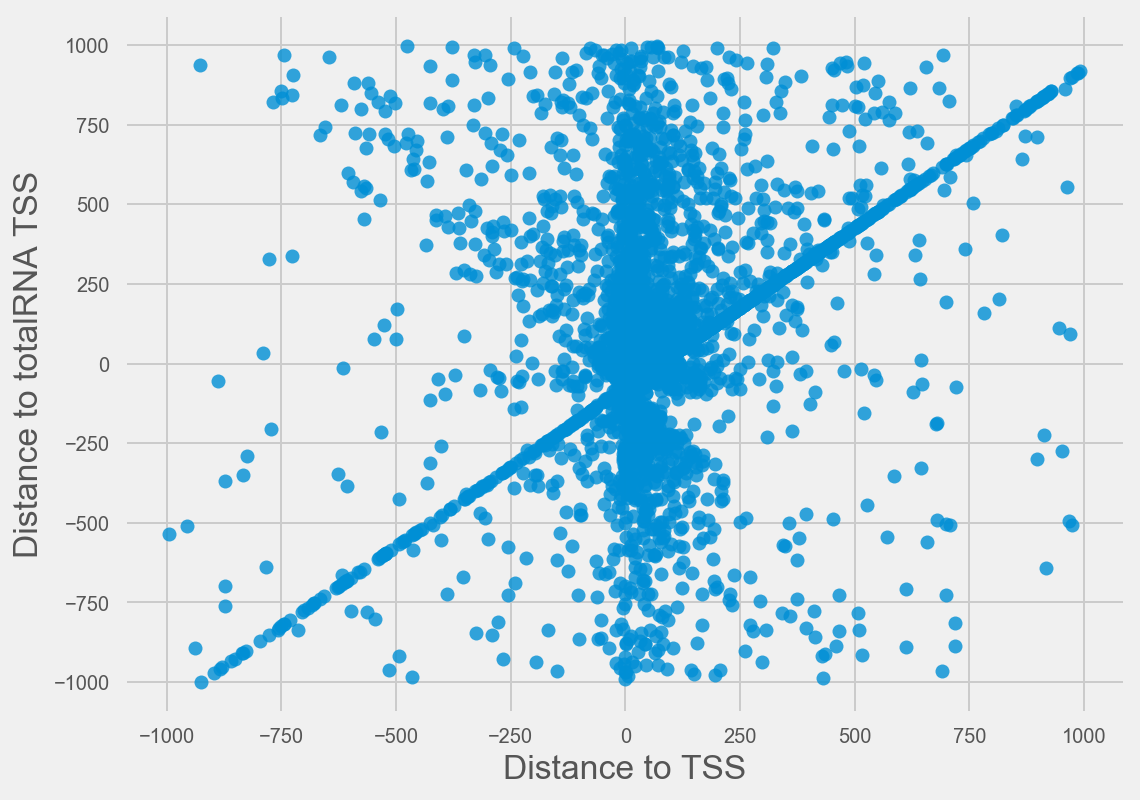

In [31]:
#plt.scatter(peaks_totalRNA.loc[peak_list,'Distance to TSS'],peaks_totalRNA.loc[peak_list,'Distance to TSS type alt'])
ax = sns.regplot(peaks_totalRNA.loc[peak_list,'Distance to TSS'],peaks_totalRNA.loc[peak_list,'Distance to TSS type alt']
           ,fit_reg=False)
ax.set_ylabel("Distance to totalRNA TSS");

In [32]:
len(peaks_totalRNA.loc[peak_list,'Distance to TSS'])

4954

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


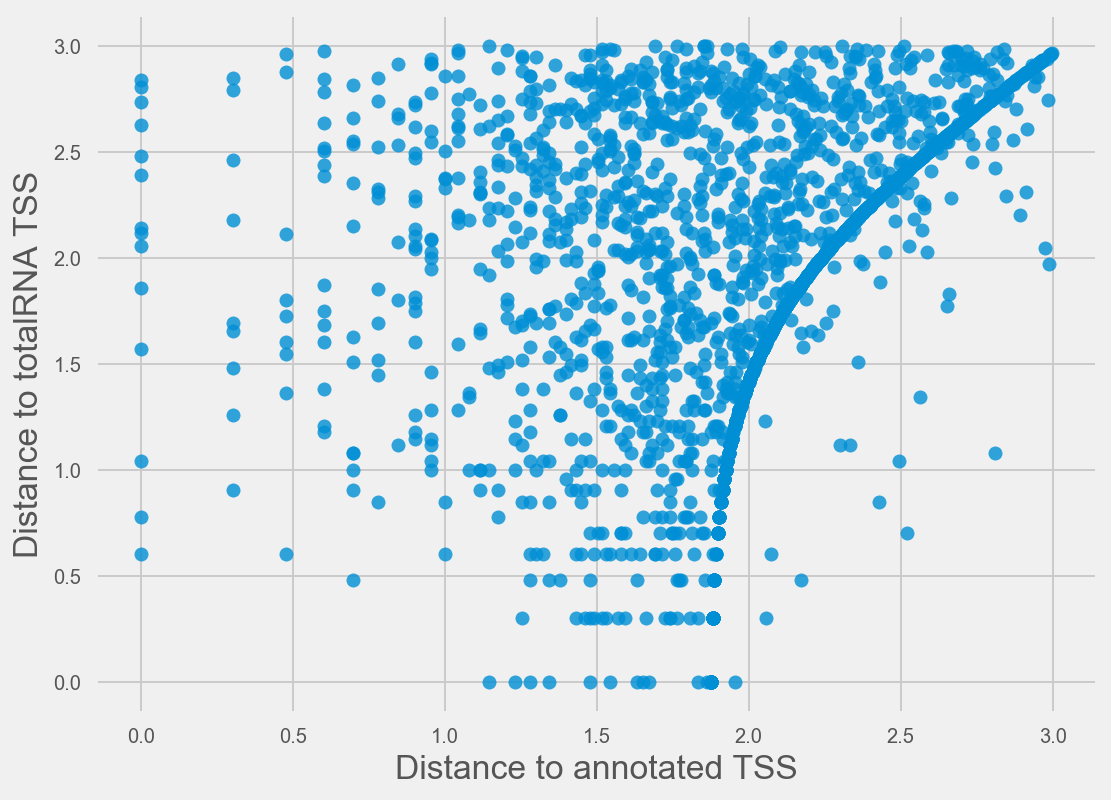

In [34]:
sns.regplot(np.log10(peaks_totalRNA.loc[peak_list,'Distance to TSS']+1),
            np.log10(peaks_totalRNA.loc[peak_list,'Distance to TSS type alt']+1),fit_reg=False)
plt.xlabel('Distance to annotated TSS')
plt.ylabel('Distance to totalRNA TSS')

## Parallelization

In [41]:
import itertools

In [155]:
test_df_output = parallel_df(peak_anno,test_df,func_args=('new_col',0))